In [115]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo

# Check power spectrum calculation

Figure out how to identify thin shells

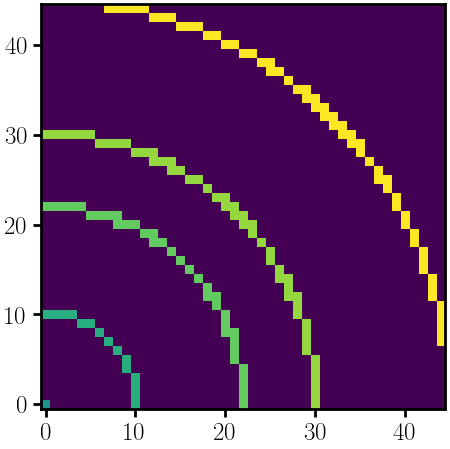

In [116]:
zeros = np.zeros((45, 45))

radius_list = [0, 10, 22, 30, 45]

for radius in radius_list:
    for x, row in enumerate(zeros):
        for y, pixel in enumerate(row):
            if radius == round(np.sqrt((x ** 2) + (y ** 2))):
                # for this plot, just color in the pixel so we can see which pixels the conditional is picking out
                zeros[x][y] += radius + 50

plt.imshow(zeros, origin='lower')
plt.show()

Make some test data

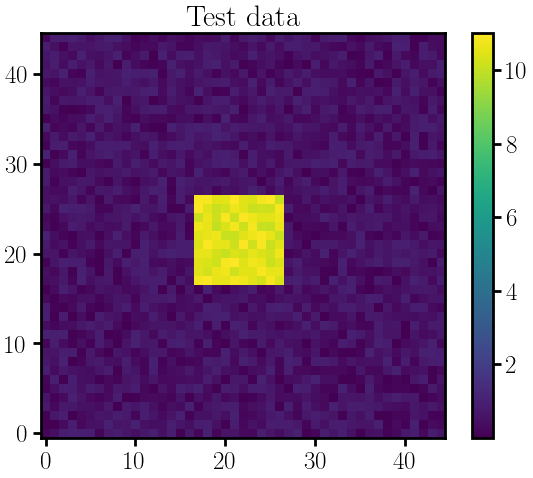

In [117]:
image = np.random.rand(45, 45)

signal_size = 10  # pixels
signal_strength = 10

# convert test signal size to inverse arcseconds
signal_size_arcsec = signal_size * 0.11

# create signal
signal = np.ones((signal_size, signal_size)) * signal_strength

# add signal to noise
min, max = 22 - (signal_size // 2), 22 + (signal_size // 2)
image[min:max, min:max] += signal

plt.imshow(image, origin='lower')
plt.colorbar()
plt.title('Test data')
plt.show()

Set the x-axis

In [118]:
k_min = (2 * np.pi) / 4.95
k_max = (2 * np.pi) / 0.11

k_array = np.linspace(k_min, k_max, 45, endpoint=True)
print(k_array)
print(len(k_array))

[ 1.26933037  2.53866073  3.8079911   5.07732146  6.34665183  7.61598219
  8.88531256 10.15464292 11.42397329 12.69330365 13.96263402 15.23196438
 16.50129475 17.77062511 19.03995548 20.30928584 21.57861621 22.84794657
 24.11727694 25.3866073  26.65593767 27.92526803 29.1945984  30.46392876
 31.73325913 33.00258949 34.27191986 35.54125022 36.81058059 38.07991095
 39.34924132 40.61857168 41.88790205 43.15723241 44.42656278 45.69589314
 46.96522351 48.23455387 49.50388424 50.7732146  52.04254497 53.31187533
 54.5812057  55.85053606 57.11986643]
45


Now work on the y-axis

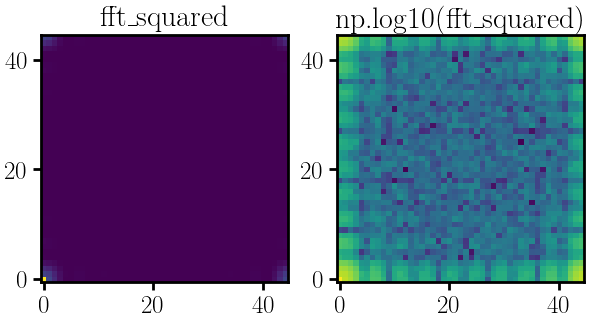

In [119]:
fft = np.fft.fft2(image)
fft_squared = np.square(np.abs(fft))

f, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(fft_squared, origin='lower')
ax[1].imshow(np.log10(fft_squared), origin='lower')

ax[0].set_title('fft_squared')
ax[1].set_title('np.log10(fft_squared)')

plt.show()

In [120]:
power_list = []
radius_list = range(45)

for radius in radius_list:
    power_per_radius = []
    for x, row in enumerate(fft_squared):
        for y, pixel in enumerate(row):
            if radius == round(np.sqrt((x ** 2) + (y ** 2))):
                power_per_radius.append(fft_squared[x][y])

    power_list.append(np.sum(power_per_radius))

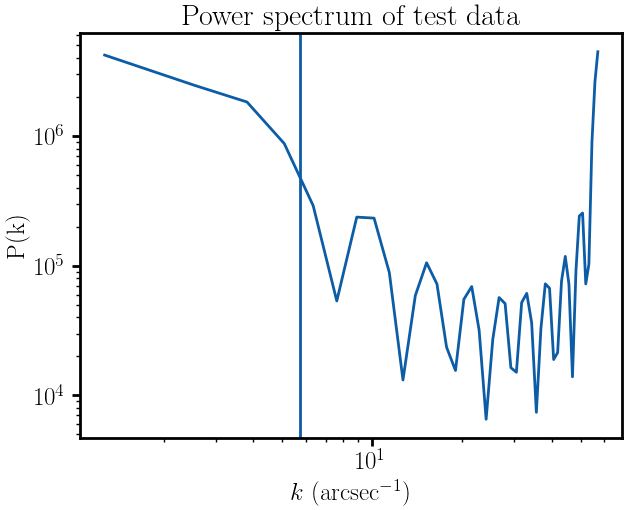

In [121]:
plt.loglog(k_array, power_list)
plt.axvline((2 * np.pi) / signal_size_arcsec)

plt.xlabel(r'$k$ (arcsec$^{-1}$)')
plt.ylabel(r'P(k)')
plt.title('Power spectrum of test data')
plt.show()

In [122]:
def power_spectrum(image):
    fft = np.fft.fft2(image)
    fft_squared = np.square(np.abs(fft))

    power_list = []
    radius_list = range(image.shape[0])

    for radius in radius_list:
        power_per_radius = []
        for x, row in enumerate(fft_squared):
            for y, _ in enumerate(row):
                if radius == round(np.sqrt((x ** 2) + (y ** 2))):
                    power_per_radius.append(fft_squared[x][y])

        power_list.append(np.sum(power_per_radius))

    return power_list

# Load strong lenses with various subhalo populations

In [123]:
input_dir = os.path.join(config.machine.data_dir, 'output', 'power_spectrum_galsim')

no_cut_model = np.load(os.path.join(input_dir, 'no_cut_model.npy'))
cut_7_model = np.load(os.path.join(input_dir, 'cut_7_model.npy'))
cut_8_model = np.load(os.path.join(input_dir, 'cut_8_model.npy'))

Take a quick look

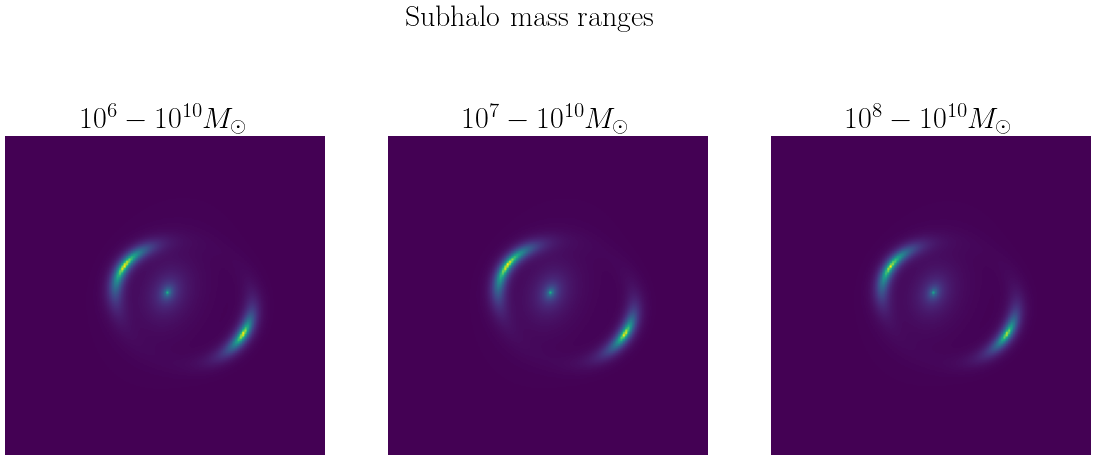

In [124]:
f, ax = plt.subplots(1, 3, figsize=(14, 6))
ax[0].imshow(no_cut_model)
ax[0].set_title(r'$10^6-10^{10}M_\odot$')
ax[1].imshow(cut_7_model)
ax[1].set_title(r'$10^7-10^{10}M_\odot$')
ax[2].imshow(cut_8_model)
ax[2].set_title(r'$10^8-10^{10}M_\odot$')
for i in ax: i.set_axis_off()

plt.suptitle('Subhalo mass ranges')
plt.show()

In [125]:
# dif_no_8 = no_cut_model - cut_8_model
# dif_no_7 = no_cut_model - cut_7_model
# dif_7_8 = cut_7_model - cut_8_model

# f, ax = plt.subplots(1, 3, figsize=(14, 6))
# ax[0].imshow(dif_no_8, cmap='bwr', **plot_util.set_v([dif_no_8]))
# ax[0].set_title(r'No cut - cut at $10^8 M_\odot$')
# ax[1].imshow(dif_no_7, cmap='bwr', **plot_util.set_v([dif_no_7]))
# ax[1].set_title(r'No cut - cut at $10^7 M_\odot$')
# ax[2].imshow(dif_7_8, cmap='bwr', **plot_util.set_v([dif_7_8]))
# ax[2].set_title(r'Cut at $10^7 M_\odot$ - cut at $10^8 M_\odot$')
# for i in ax: i.set_axis_off()
# plt.show()

In [126]:
k_min = (2 * np.pi) / 4.95
k_max = (2 * np.pi) / 0.11

k_array = np.linspace(k_min, k_max, no_cut_model.shape[0], endpoint=True)

In [127]:
no_cut_power = power_spectrum(no_cut_model)
cut_7_power = power_spectrum(cut_7_model)
cut_8_power = power_spectrum(cut_8_model)

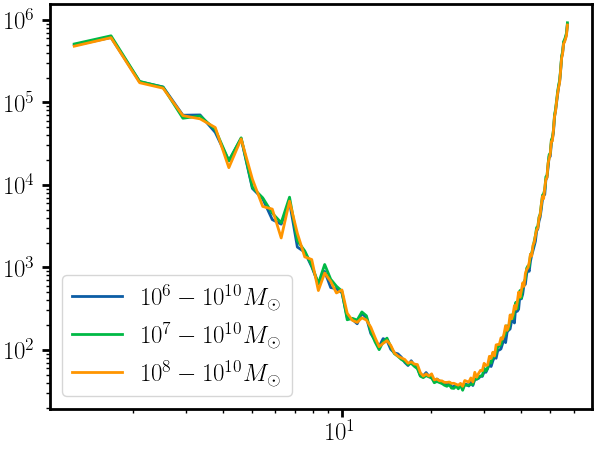

In [128]:
plt.loglog(k_array, no_cut_power, label=r'$10^6-10^{10}M_\odot$')
plt.loglog(k_array, cut_7_power, label=r'$10^7-10^{10}M_\odot$')
plt.loglog(k_array, cut_8_power, label=r'$10^8-10^{10}M_\odot$')
plt.legend()
plt.show()